# Pràctica Cas Kaggle 
## CS:GO Competitive Matchmaking Data

### 0. Contexte
#### Què és CS:GO?

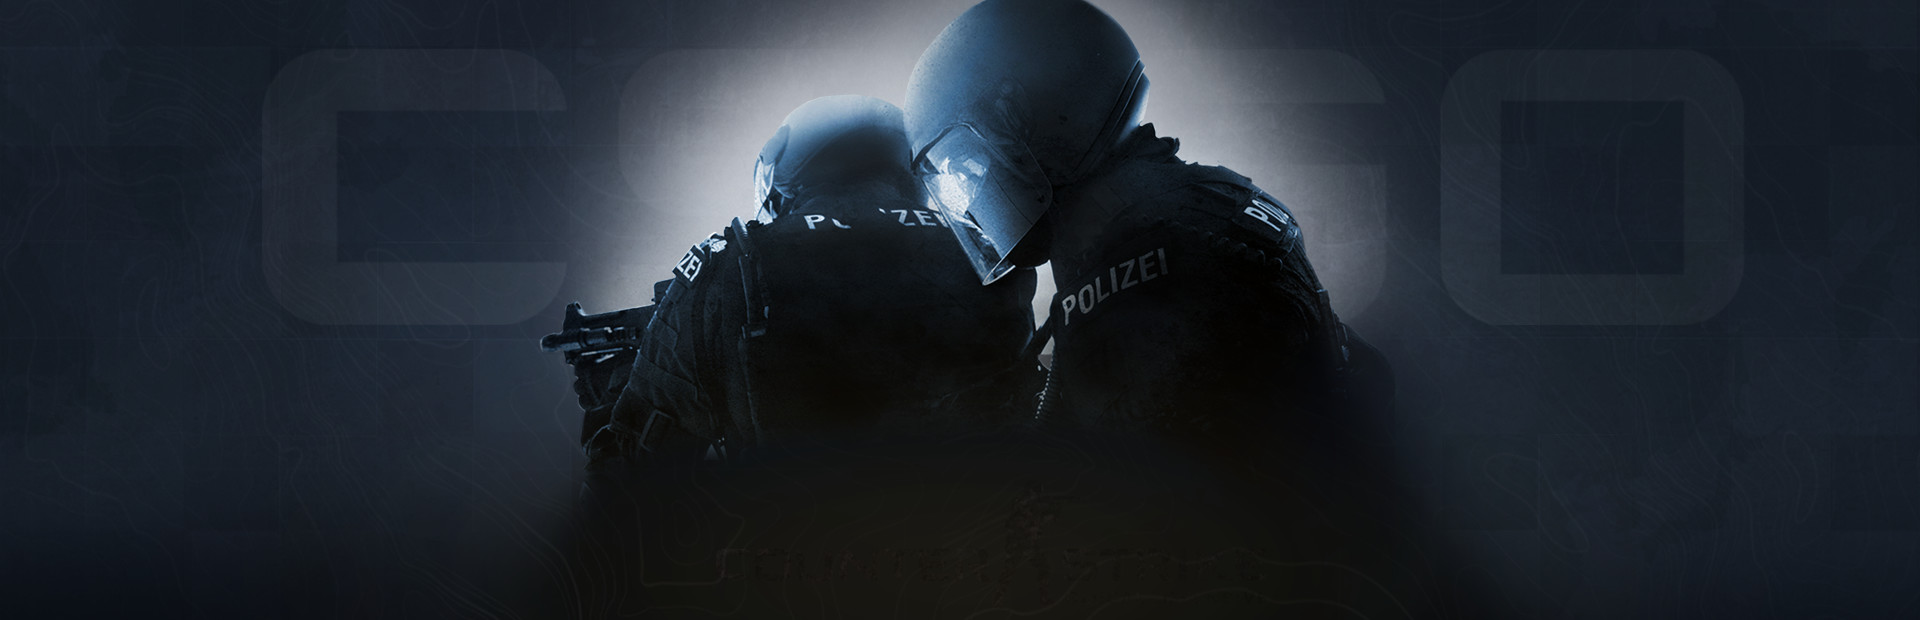

Counter Strike: Global Offensive és un videojoc multijugador gratuit per a ordinadors desenvolupat per Valve Corporation. El mode de joc principal consisteix en que un equip (Terrorists) intenten plantar una bomba en uns punts del mapa (marcats A o B) mentres que l'altre equip (Counter-Terrorists) intenta evitar-lo, i en cas de que la bomba sigui plantada han de desactivar-la.

Altres regles del joc inclouen:
* En cada equip hi ha 5 jugadors.
* Les partides consisteixen de 30 rondes com a màxim.
* Una ronda s'acaba quan un dels equips asoleix l'objectiu o s'acaba el temps. Si s'acaba el temps, guanyen els Counter-Terrorists.
* A partir de la ronda 15, els equips es canvien i es continua jugant fins que un dels equips aconsegueixi 16 rondes guanyades.

#### Xifres
* És un dels videojocs mes jugats i amb millors ingresos econòmics de la plataforma Steam
* Te un pic de al voltant de **1 millió de jugadors simultanis cada dia** [1]
* S'estima el nombre de jugadors totals entre **270 milions i 677.22 milions**[1]. No es un nombre exacte ja que Steam no revela el nombre de jugadors.
* A Twitch, la plataforma d'streaming de partides de videojocs més importants, va tindre un pic de **1,9 milions d'espectadors simultanis** al novembre de 2021. Moltes vegades está en el top 10 de videojocs mes vists[3]
* És una de les principals disciplines d'e-sports en termes de popularitat i reconeixement, amb una comunitat activa i apassionada
* Ofereix una alta quantitat de premis en efectiu i reconeixements als millors jugadors i equips, cosa que atrau molts professionals i aficionats a competir en els tornejos de Counter-Strike.

[1] Source: https://steamdb.info/app/730/graphs/

[2] Source: https://twitchtracker.com/games/32399

[3] Source: https://www.twitch.tv/directory?sort=VIEWER_COUNT

#### La base de dades

El conjunt de dades CS:GO Competitive Matchmaking Data conté informació sobre partides de Counter-Strike: Global Offensive en el mode competitiu. El conjunt de dades inclou informació detallada sobre cada partida, com la data i l'hora en què es va jugar, el mapa, els equips i els jugadors que van participar, i el resultat de la partida.

També inclou informació sobre kills, morts, danys causats, etc. A més, també conté informació sobre les armes i equipament que van utilitzar els jugadors a cada partida.

Aquest conjunt de dades pot ser útil per analitzar i entendre com afecten diferents factors el resultat duna partida de CS:GO, i com es relacionen entre si. També serà útil per fer prediccions sobre el resultat duna partida.

#### Objectiu

L'objectiu és predir quin dels dos sides guanyará la ronda, a partir de les dades de la partida.

### 1. Lectura del dataset

In [1]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

c:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Funcions per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# La majoria de les dades estan separades en multiples fitxers. Funcio util per a llegir totes les parts
def load_split_dataset(path, parts):
    dataset = pd.concat([pd.read_csv(path + ".part%d.csv" % x, header=0, delimiter=',') for x in range(1,parts+1)])
    return dataset

#### Dades dels mapes

In [3]:
# Carreguem dades dels mapes
map_data = load_dataset('../dataset/map_data.csv')
map_data

,Unnamed: 0,EndX,EndY,ResX,ResY,StartX,StartY
0,de_cache,3752,3187,1024,1024,-2031,-2240
1,de_cbble,2282,3032,1024,1024,-3819,-3073
2,de_dust2,2127,3455,1024,1024,-2486,-1150
3,de_inferno,2797,3800,1024,1024,-1960,-1062
4,de_mirage,1912,1682,1024,1024,-3217,-3401
5,de_overpass,503,1740,1024,1024,-4820,-3591
6,de_train,2262,2447,1024,1024,-2436,-2469


Conté informació dels mapes del joc. Nom i cordenades Start i End. "Res" indica la resolució del fitxer PNG que ve inclos amb el dataset per a cada mapa.

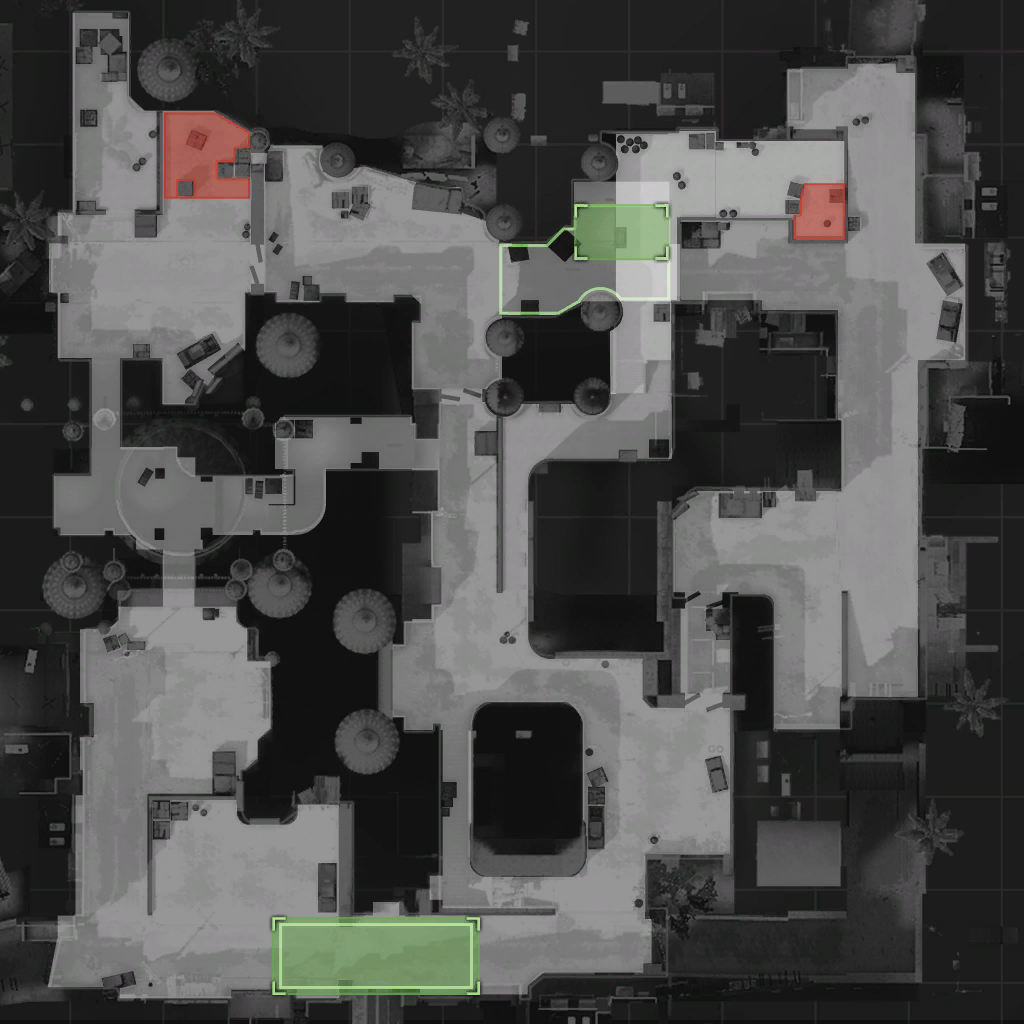
Exemple del mapa "de_dust2"

#### Dades de partides: servidors professionals ESEA https://play.esea.net/

In [4]:
# Carreguem dades de "meta"
meta_data = load_split_dataset('../dataset/esea_meta_demos', 2)
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377629 entries, 0 to 161709
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   file           377629 non-null  object 
 1   map            377629 non-null  object 
 2   round          377629 non-null  int64  
 3   start_seconds  377589 non-null  float64
 4   end_seconds    377589 non-null  float64
 5   winner_team    377628 non-null  object 
 6   winner_side    377629 non-null  object 
 7   round_type     377629 non-null  object 
 8   ct_eq_val      377629 non-null  int64  
 9   t_eq_val       377629 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 31.7+ MB


Conté informació general de les partides. Explicació atributs:

**file**: Arxiu "dem" que emmagatzema la repetició de la partida. Identificador

**map**: nom del mapa utilitzat per a jugar la partida.

**round**: Numero de ronda

**start_seconds, end_seconds**: marca de temps en la qual comença / acaba la ronda.

**winner_team, winner_side** (categ.): equip i banda que ha guanyat la ronda.

**round_type** (categ.): tipus de ronda. Ex: NORMAL, PISTOL_ROUND, FORCE_BUY...

**ct_eq_val, t_eq_val**: Valor que ha invertit cada banda en equipament.


In [5]:
# Carreguem dades de "damage"
dmg_data = load_split_dataset('../dataset/esea_master_dmg_demos', 2)
dmg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10538182 entries, 0 to 4546084
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   tick             int64  
 3   seconds          float64
 4   att_team         object 
 5   vic_team         object 
 6   att_side         object 
 7   vic_side         object 
 8   hp_dmg           int64  
 9   arm_dmg          int64  
 10  is_bomb_planted  bool   
 11  bomb_site        object 
 12  hitbox           object 
 13  wp               object 
 14  wp_type          object 
 15  att_id           int64  
 16  att_rank         int64  
 17  vic_id           int64  
 18  vic_rank         int64  
 19  att_pos_x        float64
 20  att_pos_y        float64
 21  vic_pos_x        float64
 22  vic_pos_y        float64
dtypes: bool(1), float64(5), int64(8), object(9)
memory usage: 1.8+ GB


Explicació atributs:



**tick, seconds**: Indica el temps. Els ticks son els moments en que s'actualitza el mon del joc, típicament son 64 o 128 ticks per segon. Ofereixen mes precisió pero no els utilitzarem.

**att_team, att_side**: Equip i banda del jugador que ataca

**vic_team, vic_side**: Equip i banda de la víctima

**hp_dmg**:

**arm_dmg**:

**is_bomb_planted**: Indica si els terroristes han plantat la bomba.

**bomb_site**: En cas de que han plantat la bomba, en quin punt es troba? (A o B)

**hitbox**: On ha encertat la bala al disparar. Exemple: Head, Stomach, Chest... o Generic

**wp**: Nom de l'arma que ha disparat. Ex: Glock, USP...

**wp_type**: Tipus de l'arma que ha disparat. Ex: Pistol, Rifle...

**att_id, att_rank, vic_id, vic_rank**: ID i rang dels dos jugadors. Sembla que hi ha molts missing values i no influeix en la partida. Es pot descartar?

**att_pos_x, att_pos_y; vic_pos_x, vic_pos_y**: Posicions en el mapa dels dos jugadors.

In [6]:
# Drop atributs que no ens interessen
dmg_data = dmg_data.drop(columns=['tick','att_id','att_rank','vic_id','vic_rank'])

In [7]:
# Carreguem dades de "grenades"
grenades_data = load_split_dataset('../dataset/esea_master_grenades_demos', 2)
grenades_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5246458 entries, 0 to 2256397
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   seconds          float64
 3   att_team         object 
 4   vic_team         object 
 5   att_id           int64  
 6   vic_id           float64
 7   att_side         object 
 8   vic_side         object 
 9   hp_dmg           int64  
 10  arm_dmg          int64  
 11  is_bomb_planted  bool   
 12  bomb_site        object 
 13  hitbox           object 
 14  nade             object 
 15  att_rank         int64  
 16  vic_rank         float64
 17  att_pos_x        float64
 18  att_pos_y        float64
 19  nade_land_x      float64
 20  nade_land_y      float64
 21  vic_pos_x        float64
 22  vic_pos_y        float64
dtypes: bool(1), float64(9), int64(5), object(8)
memory usage: 925.6+ MB


Explicació atributs:

nade:

nade_land_x, nade_land_y:

Utilitzarem aquestes dades?


In [8]:
# Drop atributs que no ens interessen
grenades_data = grenades_data.drop(columns=['att_id','att_rank','vic_id','vic_rank'])

In [9]:
# Carreguem dataset de kills
kills_data = load_split_dataset('../dataset/esea_master_kills_demos', 2)
kills_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2742646 entries, 0 to 1173168
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   tick             int64  
 3   seconds          float64
 4   att_team         object 
 5   vic_team         object 
 6   att_side         object 
 7   vic_side         object 
 8   wp               object 
 9   wp_type          object 
 10  ct_alive         int64  
 11  t_alive          int64  
 12  is_bomb_planted  bool   
dtypes: bool(1), float64(1), int64(4), object(7)
memory usage: 274.6+ MB


Explicació dels atributs:

ct_alive, t_alive: quants jugadors queden vius en cada banda.

Aquestes dades semblen les mes útils per a fer models. Son mes "globals"

In [10]:
# Drop atributs que no ens interessen
kills_data = kills_data.drop(columns=['tick','att_team','vic_team'])

#### Dades de partides: Matchmaking servidors oficials

In [11]:
# Carregar dades de MM
mm_master_demos = load_dataset('../dataset/mm_master_demos.csv')
mm_master_demos.info()

#mm_grenades_demos = load_dataset('dataset/mm_grenades_demos.csv')
#mm_grenades_demos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955466 entries, 0 to 955465
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       955466 non-null  int64  
 1   file             955466 non-null  object 
 2   map              955466 non-null  object 
 3   date             955466 non-null  object 
 4   round            955466 non-null  int64  
 5   tick             955466 non-null  int64  
 6   seconds          955466 non-null  float64
 7   att_team         955466 non-null  object 
 8   vic_team         955466 non-null  object 
 9   att_side         955466 non-null  object 
 10  vic_side         955466 non-null  object 
 11  hp_dmg           955466 non-null  int64  
 12  arm_dmg          955466 non-null  int64  
 13  is_bomb_planted  955466 non-null  bool   
 14  bomb_site        151039 non-null  object 
 15  hitbox           955466 non-null  object 
 16  wp               955466 non-null  obje

In [12]:
# Quantes dades de partides tenim?
mm_master_demos.groupby('file').count().count()

Unnamed: 0         1297
map                1297
date               1297
round              1297
tick               1297
seconds            1297
att_team           1297
vic_team           1297
att_side           1297
vic_side           1297
hp_dmg             1297
arm_dmg            1297
is_bomb_planted    1297
bomb_site          1297
hitbox             1297
wp                 1297
wp_type            1297
award              1297
winner_team        1297
winner_side        1297
att_id             1297
att_rank           1297
vic_id             1297
vic_rank           1297
att_pos_x          1297
att_pos_y          1297
vic_pos_x          1297
vic_pos_y          1297
round_type         1297
ct_eq_val          1297
t_eq_val           1297
avg_match_rank     1297
dtype: int64

In [13]:
# Drop atributs que no ens interessen
mm_master_demos = mm_master_demos.drop(columns=['tick','date','award','att_id','att_rank','vic_id','vic_rank','avg_match_rank'])

### 2. Anàlisi de les dades

In [14]:
# TODO: preprocesament:
# eliminar outliers? mirar correlacions y todo

In [15]:
# Mostrar tots els equips
meta_data['winner_team'].value_counts()

Team 1                  192564
Team 2                  184262
Team Kinguin                74
Izako Boars                 57
PRiDE                       49
MVP PK                      48
ALTERNATE aTTaX             46
--to be determined--        41
SZ Absolute                 41
EURONICS Gaming             32
Ground Zero                 32
Sprout                      32
AGO Esports                 32
Chiefs                      32
Grayhound                   31
Endpoint                    31
PACT                        27
Dynasty                     25
BOOT-dS Letou               24
SYF                         22
FlashGaming                 19
Legacy                      16
Hentai Hooligans            15
Guerrilla Tactics           15
Taboo                       14
x-kom Team                  11
Animal Style                 9
ONCA Gaming                  8
fish123                      8
Cerus eSports                7
anime savants                4
Name: winner_team, dtype: int64

Hi ha un parell d'equips que son placeholders perque no s'ha registrat quin equip ha guanyat. Aixo fa que no sigui usable, eliminem.

In [16]:
# Eliminem columna
meta_data = meta_data.drop('winner_team', axis=1)
#dmg_data.drop('vic_team', axis=1)
#dmg_data.drop('att_team', axis=1)
#kills_data.drop('vic_team', axis=1)
#kills_data.drop('att_team', axis=1)

#grenades_data.drop('vic_team', axis=1)
#grenades_data.drop('att_team', axis=1)
mm_master_demos = mm_master_demos.drop(columns=['vic_team','att_team'])

<AxesSubplot:ylabel='winner_side'>

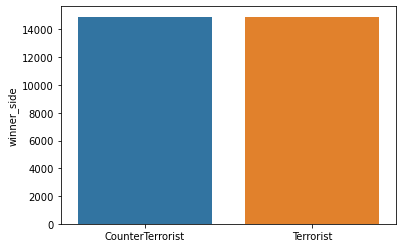

In [17]:
# Quin equip (side) guanya mes? (en ESEA)
side_counts = meta_data.groupby(['file','winner_side']).count().reset_index()['winner_side'].value_counts().head(2)
sns.barplot(x=side_counts.index, y=side_counts)

<AxesSubplot:ylabel='winner_side'>

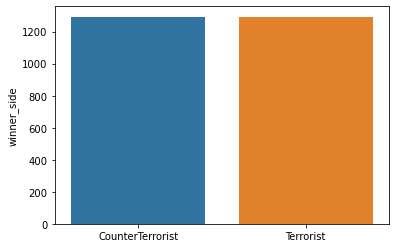

In [18]:
# Quin equip (side) guanya mes? (en matchmaking)
side_counts = mm_master_demos.groupby(['file','winner_side']).count().reset_index()['winner_side'].value_counts()
sns.barplot(x=side_counts.index, y=side_counts)

<AxesSubplot:ylabel='map'>

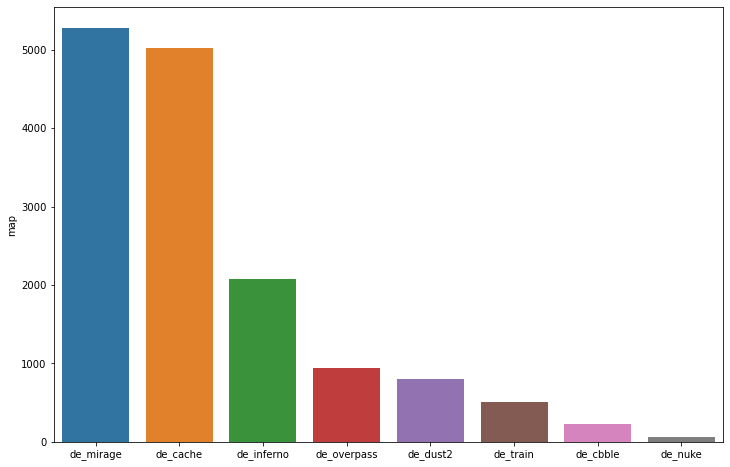

In [19]:
# Quins son els mapes mes populars? (ESEA)
side_counts = meta_data.groupby(['file','map']).count().reset_index()['map'].value_counts().head(10)
plt.subplots(figsize = (12,8))
sns.barplot(x=side_counts.index, y=side_counts)

<AxesSubplot:ylabel='map'>

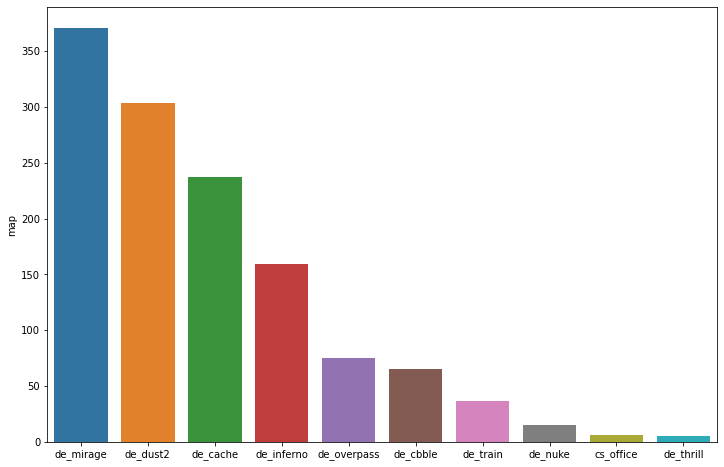

In [20]:
# Quins son els mapes mes populars? (matchmaking)
side_counts = mm_master_demos.groupby(['file','map']).count().reset_index()['map'].value_counts().head(10)
plt.subplots(figsize = (12,8))
sns.barplot(x=side_counts.index, y=side_counts)

In [21]:
# Codificar variables categóriques
meta_data["winner_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : 1, np.NaN:1}, inplace=True)
#meta_data["round_type"].replace({'PISTOL_ROUND':0, 'ECO':1, 'SEMI_ECO':2, 'NORMAL':3, 'FORCE_BUY':4}, inplace=True)

kills_data["att_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : -1}, inplace=True)
kills_data["vic_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : -1}, inplace=True)
kills_data["is_bomb_planted"].replace({False:0, True: 1}, inplace=True)


mm_master_demos["att_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : np.NaN}, inplace=True)
mm_master_demos["vic_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : np.NaN}, inplace=True)
mm_master_demos["winner_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : 1, np.NaN:1}, inplace=True)
mm_master_demos["bomb_site"].replace({np.NaN:-1, 'A': 0, 'B' : 1}, inplace=True)
mm_master_demos["hitbox"].replace({'Head': 0, 'RightLeg' : 1, 'LeftLeg': 2, 'Chest':3, 'Stomach': 4, 'RightArm': 5, 'Generic': 6, 'LeftArm': 7}, inplace=True)
mm_master_demos["wp"].replace({'USP':0, 'Glock':1, 'P2000':2, 'HE':3, 'Tec9':4, 'Deagle':5, 'MP9':6, 'UMP':7, 'Famas':8, 'P250':9, 'AK47':10, 'AWP':11, 'MP7':12, 'M4A1':13, 'FiveSeven':14, 'Incendiary':15, 'Scout':16, 'Unknown':17, 'Knife':18, 'Bizon':19, 'Flash':20, 'CZ':21, 'M4A4':22, 'Molotov':23, 'P90':24, 'AUG':25, 'Gallil':26, 'G3SG1':27, 'M249':28, 'SG556':29, 'Mac10':30, 'XM1014':31, 'DualBarettas':32, 'Nova':33, 'Swag7':34, 'Zeus':35, 'Scar20':36, 'SawedOff':37, 'Smoke':38, 'Negev':39, 'Decoy':40, 'Bomb':41}, inplace=True)
mm_master_demos["wp_type"].replace({'Pistol':0, 'Grenade':1, 'SMG':2, 'Rifle':3, 'Sniper':4, 'Unkown':5, 'Equipment':6, 'Heavy':7}, inplace=True)
#mm_master_demos["round_type"].replace({'PISTOL_ROUND':0, 'ECO':1, 'SEMI_ECO':2, 'NORMAL':3, 'FORCE_BUY':4}, inplace=True)


# One-hot encoding
#round type y map TODO

In [22]:
mm_master_demos["round_type"].unique()

array(['PISTOL_ROUND', 'ECO', 'SEMI_ECO', 'NORMAL', 'FORCE_BUY'],
      dtype=object)

#### Quines dades utilitzarem per a fer machine learning?
Les dades que trobem als dataframes de grenades i dmg aporten informació massa precisa d'un moment en concret del joc. Necessitem dades mes globals, com les que trobem a kills i meta. En el cas de MM, no utilitzarem aquestes dades perque el mostreig és molt petit, de nomes 1297 partides. A més, no tenim dades de les "kills" de cada equip i tenim el mateix problema que amb les dades de granedes i dmg.

In [23]:
# No farem servir dades de "grenades" ni "damage", nomes de "kills". Eliminem les dades carregades per estalviar memòria.
del(grenades_data)
del(dmg_data)
del(mm_master_demos)

In [24]:
# Juntar dades de meta_data i kills_data
m = pd.merge(kills_data, meta_data)
del(kills_data)
del(meta_data)

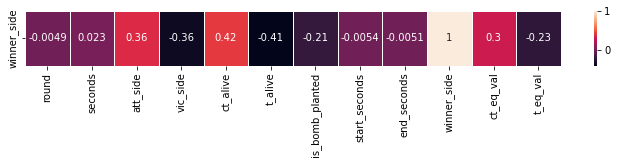

In [25]:
correlacio = m.corr()['winner_side'].to_frame().T
plt.subplots(figsize = (12,1))
#plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Farem servir els seguents atributs, ja que tenen correlació amb l'objectiu:
* Quants jugadors T queden vius
* Quants jugadors CT queden vius
* La bomba ha sigut plantada (pels T)
* Quantitat invertida en armes pels T
* Quantitat invertida en armes pels CT

att_side i vic_side no els utilitzarem encara que tinguin correlació, ja que es refereix a una "kill" en concret i necessitem la dada global de morts en la ronda, que ja obtenim de t_alive i ct_alive.

No és necessari aplicar PCA o altres tècniques de reducció de dimensionalitat ja que tenim pocs atributs.

### 3. Implementació de models

El nostre objectiu es predir una categoria (quina banda guanya una ronda). Podem utilitzar els següents models:
* Regressió logística
* Linear SVC
* Arbres de decisió
* KNeighbours Classifier
* Random forest???
* Multi-layer perceptron???

Per a optimitzar els hyperparàmetres podem utilitzar la funció **GridSearchCV**. La manera en què funciona GridSearchCV és que se li proporciona una llista de valors possibles per a cada paràmetre del model que es vol optimitzar. Després, l'algoritme de cerca de quadrícula combina tots aquests valors possibles en diferents combinacions i entrena un model per a cada combinació. Finalment, avalua cada model i selecciona el que té el millor rendiment.

Alguns dels paràmetres que utilitzo en tots els models son:
* max_iter: per a augmentar el nombre d'iteracions i que no es quedi a mitjes abans de que arribi a la convergencia
* verbose=True: per saber el progres. Útil en els models més complexos que poden trigar més de 20 min.
* n_jobs=-1: Utilitza tots els threads de la CPU.

In [26]:
y = m['winner_side']
X = m[['ct_alive','t_alive','is_bomb_planted','ct_eq_val','t_eq_val']]

# Dividir dades entre test i train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

#### Regressió logistica

In [27]:
start = time.time()  # Get the current time

# Logistic Regression using GridSearchCV
lr = LogisticRegression(max_iter=1000, verbose=1)
parameters = {'fit_intercept':[True,False], 'C': [0.1, 1, 10, 100]}
clf = GridSearchCV(lr, parameters)
clf.fit(X_train, y_train)
# Calculate the time difference
time_elapsed = time.time() - start
print(f"Time elapsed(train): {time_elapsed} seconds")

print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

start = time.time()  # Get the current time

y_pred = clf.predict(X_test)

# Calculate the time difference
time_elapsed = time.time() - start
print(f"Time elapsed (predict): {time_elapsed} seconds")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Time elapsed(train): 81.34375619888306 seconds
Best score: 0.811168353038558
Best parameters: {'C': 1, 'fit_intercept': True}
Time elapsed (predict): 0.05400729179382324 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82    971736
           1       0.81      0.81      0.81    916935

    accuracy                           0.81   1888671
   macro avg       0.81      0.81      0.81   1888671
weighted avg       0.81      0.81      0.81   1888671



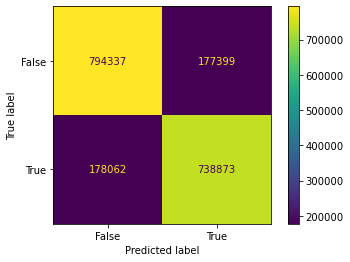

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show() 

#### Arbres de decisió

In [30]:
# Decision tree
start = time.time()  # Get the current time
parameters = {'max_depth': [3, 5, 7, 9, 11, 13, 15],
              "max_leaf_nodes": [5,10,15,20, 30, 40, 50]}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, verbose=10, n_jobs=-1)
clf.fit(X_train, y_train)
time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")

start = time.time()  # Get the current time

y_pred = clf.predict(X_test)

time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")

print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Time elapsed: 58.64548110961914 seconds
Time elapsed: 0.15400290489196777 seconds
Best score: 0.813409436269968
Best parameters: {'max_depth': 9, 'max_leaf_nodes': 50}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82    971736
           1       0.80      0.83      0.81    916935

    accuracy                           0.81   1888671
   macro avg       0.81      0.81      0.81   1888671
weighted avg       0.81      0.81      0.81   1888671



[Text(0.3692781690140845, 0.9375, 'ct_alive <= 2.5\ngini = 0.5\nsamples = 809430\nvalue = [416124, 393306]'),
 Text(0.10915492957746478, 0.8125, 't_alive <= 1.5\ngini = 0.381\nsamples = 295558\nvalue = [219766, 75792]'),
 Text(0.028169014084507043, 0.6875, 'ct_alive <= 0.5\ngini = 0.454\nsamples = 76914\nvalue = [26841, 50073]'),
 Text(0.014084507042253521, 0.5625, 'gini = 0.056\nsamples = 9543\nvalue = [9269, 274]'),
 Text(0.04225352112676056, 0.5625, 't_alive <= 0.5\ngini = 0.386\nsamples = 67371\nvalue = [17572, 49799]'),
 Text(0.028169014084507043, 0.4375, 'gini = 0.08\nsamples = 22452\nvalue = [936, 21516]'),
 Text(0.056338028169014086, 0.4375, 'ct_alive <= 1.5\ngini = 0.466\nsamples = 44919\nvalue = [16636, 28283]'),
 Text(0.028169014084507043, 0.3125, 'is_bomb_planted <= 0.5\ngini = 0.49\nsamples = 19855\nvalue = [11330, 8525]'),
 Text(0.014084507042253521, 0.1875, 'gini = 0.495\nsamples = 9135\nvalue = [4112, 5023]'),
 Text(0.04225352112676056, 0.1875, 'gini = 0.44\nsamples = 1

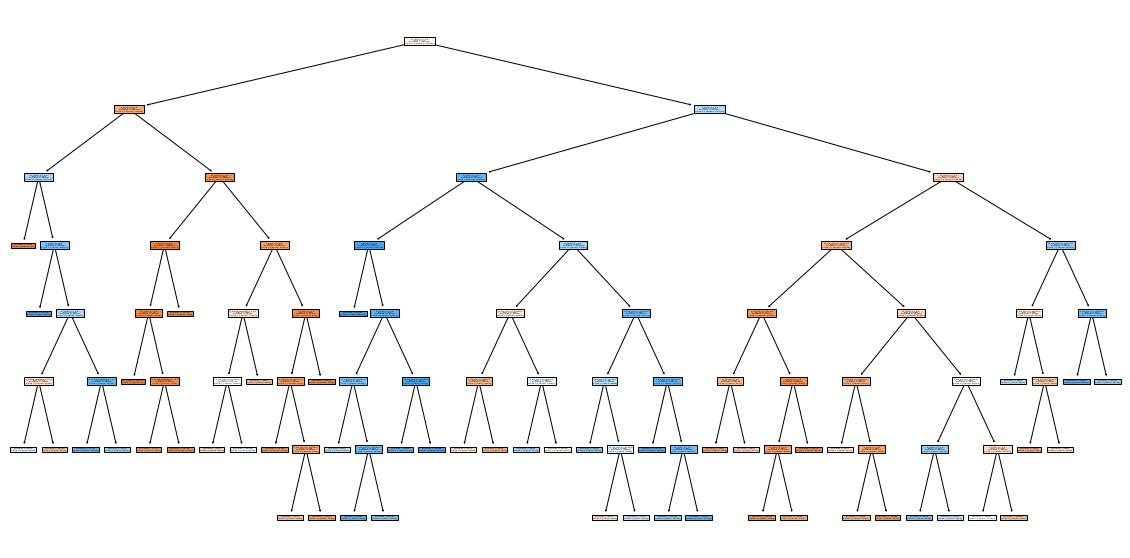

In [31]:
# Mostrar tree
plt.figure(figsize=(20,10))
plot_tree(clf.best_estimator_, filled=True, feature_names=X_train.columns)

#### Linear SVC

In [32]:
# Linear SVC, no funciona, mirar
parameters = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge']
}

start = time.time()  # Get the current time
svc = LinearSVC(max_iter=1000)
clf = GridSearchCV(svc, parameters, verbose=3, n_jobs=-1)
clf.fit(X_train, y_train)

time_elapsed = time.time() - start
print(f"Time elapsed (train): {time_elapsed} seconds")

# Predicció
start = time.time()  # Get the current time
y_pred = clf.predict(X_test)

time_elapsed = time.time() - start
print(f"Time elapsed (predict): {time_elapsed} seconds")

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .................C=0.1, loss=hinge;, score=0.528 total time= 1.8min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .................C=0.1, loss=hinge;, score=0.573 total time= 2.1min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .................C=0.1, loss=hinge;, score=0.600 total time= 1.9min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .................C=0.1, loss=hinge;, score=0.572 total time= 2.1min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .................C=0.1, loss=hinge;, score=0.780 total time= 2.1min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .........C=0.1, loss=squared_hinge;, score=0.777 total time= 2.1min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .........C=0.1, loss=squared_hinge;, score=0.637 total time= 2.0min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .........C=0.1, loss=squared_hinge;, score=0.576 total time= 2.1min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .........C=0.1, loss=squared_hinge;, score=0.802 total time= 1.9min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .........C=0.1, loss=squared_hinge;, score=0.619 total time= 2.1min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ...................C=1, loss=hinge;, score=0.739 total time= 2.1min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ...................C=1, loss=hinge;, score=0.517 total time= 1.8min


c:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ...................C=1, loss=hinge;, score=0.498 total time= 2.0min


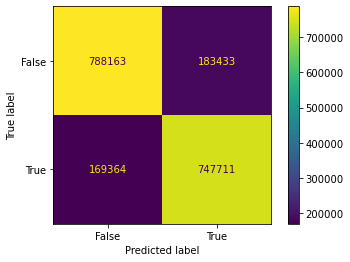

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show() 

#### KNeighbours Classifier

In [ ]:
# KNN
start = time.time()  # Get the current time
knn = KNeighborsClassifier()
parameters = {  'n_neighbors': [3,5,7,9,11],
                'weights': ['uniform', 'distance'],
                'p': [1,2,3]}
clf = GridSearchCV(knn, parameters, verbose=True, n_jobs=-1)
clf.fit(X_train, y_train)

time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")

# Predicció
start = time.time()  # Get the current time
y_pred = clf.predict(X_test)
time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")


print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

#### Random forest

In [ ]:
# Random Forest
start = time.time()  # Get the current time

parameters = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'max_depth': [3, 5, 7, 9, 11, 13, 15],
              "max_leaf_nodes": [5,10,15,20, 30, 40, 50]}

rf = RandomForestClassifier()
clf = GridSearchCV(knn, parameters, verbose=True, n_jobs=-1)
clf.fit(X_train, y_train)

time_elapsed = time.time() - start
print(f"Time elapsed(train): {time_elapsed} seconds")

start = time.time()  # Get the current time
y_pred = clf.predict(X_test)
time_elapsed = time.time() - start
print(f"Time elapsed(predict): {time_elapsed} seconds")

print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))


print(classification_report(y_test, y_pred))

Time elapsed: 126.83331799507141 seconds
Time elapsed: 72.38548493385315 seconds
              precision    recall  f1-score   support

           0       0.79      0.79      0.79    971596
           1       0.78      0.77      0.78    917075

    accuracy                           0.78   1888671
   macro avg       0.78      0.78      0.78   1888671
weighted avg       0.78      0.78      0.78   1888671



#### Multi-layer perceptron

In [ ]:
# Multi-layer perceptron. Falta hyper? no va o tarda mucho

parameters = {'hidden_layer_sizes': [(10,10,10), (10,20,10), (20,20,20)],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant','adaptive']
}

# Train
start = time.time()  # Get the current time
mlp = MLPClassifier(max_iter=1000)
clf = GridSearchCV(mlp, parameters, cv=5, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)

time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")



# Predir resultats
start = time.time()  # Get the current time
y_pred = clf.predict(X_test)
time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")

Time elapsed: 0.0 seconds


In [ ]:
# corva roc y cosas

### 4. Comparació de models

In [ ]:
# cosas

/////placeholder)////

| Model | Hiperparametres | Precision | Recall | F1 | Temps (train) | Temps(pred.)
| -- | -- | -- | -- | -- | -- | -- |
| Logistic Regression | C:0.1 | 81% | 81% | 81% | 65s | 0.0519s
| SVM | kernel: lineal C:10 | 58% | 200ms |
| Decission Tree |x|x|x|
| KNN |x| 84%| 84%| 84% | 18 min|x|
| [Random Forest](link) | 100 Trees, XX | 57% | 100ms |
| Random Forest | 1000 Trees, XX | 58% | 1000ms |
| Multi-layer perceptron |x|x|x|

### 5. Anàlisi de resultats

#cosas
El model que fa la predicció de forma més ràpida és "Decision Tree"

### 6. Final

#### Conclusions
Conclusions...

#### Treballs futurs
Com es tracta d'un videojoc, on tenim totes les dades en memoria i no necessitem sensors ni equipament com al mon real, aquest repositori es podria usar com a fonaments per a desenvolupar un programa que capti el estat d'una partida competitiva de Counter Strike i que vagi predint en tot moment quin sera el resultat de la ronda.

Per aixo s'hauria de millorar els models utilitzant menys dades "globals" (numero de jugadors restant de cada equip) i utilitzar dades mes "de cada moment" (posicio de la bomba, utilitzar dades del "dmg" i de les granades...)